In [58]:
# mypy: ignore-errors
import os
import sys
import matplotlib
import pandas as pd
import pdb
from IPython import get_ipython
from IPython.display import display


is_notebook = True if "script" not in os.getcwd() else False
recidiviz_data_path = "../../../../../../.." + ("/.." if not is_notebook else "")

sys.path.insert(0, os.path.relpath(recidiviz_data_path))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml
from recidiviz.utils.yaml_dict import YAMLDict

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.get_option("display.max_rows")

In [14]:
# Get the simulation tag from the model inputs config
yaml_file_path = (
    "../" if not is_notebook else ""
) + "pa_mj_decrim_model_inputs_full_mapping_v3.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

In [15]:
simulation_tag

'pa_mj_decrim_2023_full_mapping_v3'

In [16]:
if (is_notebook):
    get_ipython().run_line_magic('run', recidiviz_data_path + "/../recidiviz-research/utils/research_utils.py")
    adjust_plot_scale(0.4)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load simulation

In [17]:
policy_sim = SuperSimulationFactory.build_super_simulation(yaml_file_path)

Downloading: 100%|████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 567.26rows/s]


In [18]:
transitions_post_policy = pd.read_csv(
    ("../" if not is_notebook else "") + "alt_transitions_policy.csv"
)

In [19]:
pd.set_option("display.max_rows", 10)

In [20]:
policy_sim

In [56]:
policy_sim.initializer.get_data_inputs().outflows_data.head()

compartment  time_step outflow_to crime_type  total_population
0    pretrial        -60       jail    mj_plus              11.0
1    pretrial        -60       jail    only_mj              51.0
2    pretrial        -60     prison    mj_plus               8.0
3    pretrial        -60     prison    only_mj              10.0
4    pretrial        -60  probation    mj_plus              34.0

In [22]:
policy_sim.initializer.data_inputs.transitions_data.groupby(
    ["crime_type", "compartment", "outflow_to"]
).compartment_duration.count()

crime_type  compartment  outflow_to
mj_plus     jail         liberty       14
            liberty      liberty        1
            parole       liberty       25
            prison       liberty       25
                         parole        24
                                       ..
only_mj     liberty      liberty        1
            parole       liberty       18
            prison       liberty       17
                         parole        16
            probation    liberty       25
Name: compartment_duration, Length: 12, dtype: int64

In [23]:
## Policy functions
def bypass_system(compartment: str):
    return partial(
        ShellCompartment.reallocate_outflow,
        reallocation_fraction=1,
        outflow=compartment,
        new_outflow="liberty",
    )


def reallocate_prison_to_no_parole():
    return partial(
        TransitionTable.reallocate_outflow,
        reallocation_df=pd.DataFrame(
            {"outflow": "parole", "affected_fraction": 1, "new_outflow": "liberty"},
            index=[0],
        ),
        reallocation_type="*",
        retroactive=True,
    )


def resentence_policy(outflow, policy_impact_percent):
    return partial(
        TransitionTable.apply_reductions,
        reduction_df=pd.DataFrame(
            {
                "outflow": outflow,
                "affected_fraction": 1,
                "reduction_size": policy_impact_percent / 100,
            },
            index=[0],
        ),
        reduction_type="*",
        retroactive=True,
    )


def switch_to_policy_transitions():
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=transitions_post_policy,
        retroactive=True,
    )

In [24]:
# Simulate policy starting in July 2023
policy_ts = 41

In [25]:
policy_list = (
    ##################################
    # crime_type = mj_plus
    ##################################
    [
        # 1 transition table switch
        SparkPolicy(
            policy_fn=switch_to_policy_transitions(),
            spark_compartment=compartment,
            sub_population={"crime_type": "mj_plus"},
            policy_ts=policy_ts,
            apply_retroactive=True,
        )
        for compartment in ["prison", "jail", "probation", "parole"]
    ]
    ######################################
    # crime_type = only_mj
    ######################################
    + [
        # Reallocate all new admissions from pretrial to liberty
        # pretrial -> [prison, jail, probation]
        # becomes
        # pretrial -> liberty
        SparkPolicy(
            policy_fn=bypass_system(compartment),
            spark_compartment="pretrial",
            sub_population={"crime_type": "only_mj"},
            policy_ts=policy_ts,
            apply_retroactive=True,
        )
        for compartment in ["prison", "jail", "probation"]
    ]
    + [
        # Redirect all prison clients directly to liberty
        # prison -> parole
        # now
        # prison -> liberty
        SparkPolicy(
            policy_fn=reallocate_prison_to_no_parole(),
            spark_compartment="prison",
            sub_population={"crime_type": "only_mj"},
            policy_ts=policy_ts,
            apply_retroactive=True,
        )
    ]
    + [
        # 100% sentence reductions for all only_mj clients
        # * -> liberty immediately
        SparkPolicy(
            policy_fn=resentence_policy("liberty", 100),
            spark_compartment=compartment,
            sub_population={"crime_type": "only_mj"},
            policy_ts=policy_ts,
            apply_retroactive=True,
        )
        for compartment in ["prison", "jail", "probation", "parole"]
    ]
)

/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/PA/mj-decrim/../../../../../../../recidiviz/calculator/modeling/population_projection/population_simulation/population_simulation_factory.py:168: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (simulation_group_name), _ in transitions_data.groupby(disaggregation_axes):


initialization time:  3.2405948638916016
HITTING Transition table doesnt release everyone ERROR
HITTING Transition table doesnt release everyone ERROR
HITTING Transition table doesnt release everyone ERROR


/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/PA/mj-decrim/../../../../../../../recidiviz/calculator/modeling/population_projection/population_simulation/population_simulation_factory.py:168: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (simulation_group_name), _ in transitions_data.groupby(disaggregation_axes):


initialization time:  3.2710390090942383
simulation_time:  4.586997032165527
simulation_time:  4.466057062149048
2249.5


/Users/jazz/Recidiviz/pulse-data/recidiviz/calculator/modeling/population_projection/state/PA/mj-decrim/../../../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/simulator.py:320: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simulation_results = simulation_results.groupby(


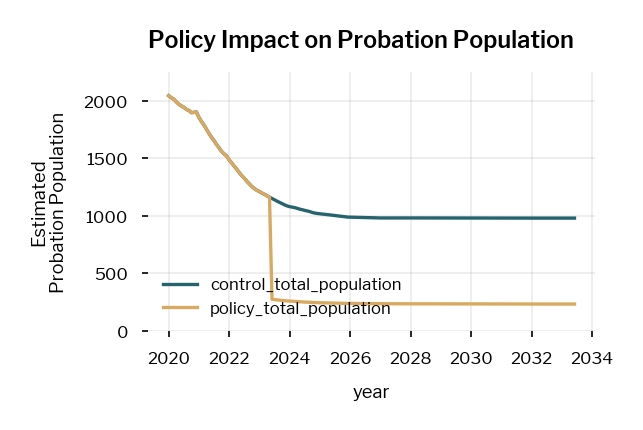

In [26]:
policy_results = policy_sim.simulate_policy(policy_list, "probation")
policy_results["population_difference"] = (
    policy_results["policy_total_population"]
    - policy_results["control_total_population"]
)

In [60]:
o = policy_sim.get_outflows_data_input()

In [65]:
o.head()

compartment outflow_to crime_type  time_step  total_population
0    pretrial       jail    mj_plus        -60              11.0
1    pretrial       jail    only_mj        -60              51.0
2    pretrial     prison    mj_plus        -60               8.0
3    pretrial     prison    only_mj        -60              10.0
4    pretrial  probation    mj_plus        -60              34.0

In [67]:
o.compartment.value_counts()

pretrial    558
Name: compartment, dtype: int64

<Axes: xlabel='time_step'>

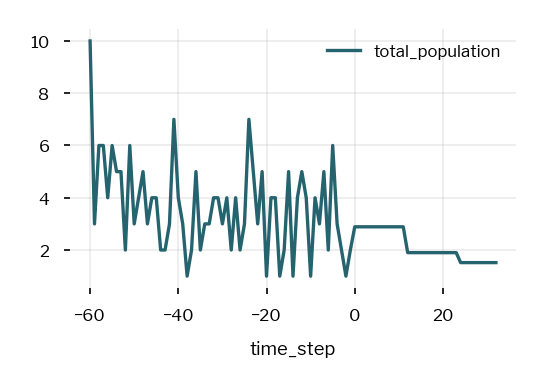

In [69]:
o[
    (o.crime_type == "only_mj")
    & (o.compartment == "pretrial")
    & (o.outflow_to == "prison")
    #   (o.policy_sim=='policy')&
][["time_step", "total_population"]].set_index("time_step").plot()

In [95]:
c = policy_sim.get_all_outflows_tables(population_simulations=["control"])
p = policy_sim.get_all_outflows_tables(population_simulations=["policy"])

In [80]:
o

policy_sim  sub_sim compartment  time_step outflow_to      outflows
0        control  mj_plus    pretrial       -120       jail     10.333333
1        control  mj_plus    pretrial       -119       jail     10.333333
2        control  mj_plus    pretrial       -118       jail     10.333333
3        control  mj_plus    pretrial       -117       jail     10.333333
4        control  mj_plus    pretrial       -116       jail     10.333333
5        control  mj_plus    pretrial       -115       jail     10.333333
6        control  mj_plus    pretrial       -114       jail     10.333333
7        control  mj_plus    pretrial       -113       jail     10.333333
8        control  mj_plus    pretrial       -112       jail     10.333333
9        control  mj_plus    pretrial       -111       jail     10.333333
10       control  mj_plus    pretrial       -110       jail     10.333333
11       control  mj_plus    pretrial       -109       jail     10.333333
12       control  mj_plus    pretrial       -108       jail     10.333333
13       control  mj_plus    pretrial       -107       jail     10.333333
14       control  mj_plus    pretrial       -106       jail     10.333333
15       control  mj_plus    pretrial       -105       jail     10.333333
16       control  mj_plus    pretrial       -104       jail     10.333333
17       control  mj_plus    pretrial       -103       jail     10.333333
18       control  mj_plus    pretrial       -102       jail     10.333333
19       control  mj_plus    pretrial       -101       jail     10.333333
20       control  mj_plus    pretrial       -100       jail     10.333333
21       control  mj_plus    pretrial        -99       jail     10.333333
22       control  mj_plus    pretrial        -98       jail     10.333333
23       control  mj_plus    pretrial        -97       jail     10.333333
24       control  mj_plus    pretrial        -96       jail     10.333333
25       control  mj_plus    pretrial        -95       jail     10.333333
26       control  mj_plus    pretrial        -94       jail     10.333333
27       control  mj_plus    pretrial        -93       jail     10.333333
28       control  mj_plus    pretrial        -92       jail     10.333333
29       control  mj_plus    pretrial        -91       jail     10.333333
30       control  mj_plus    pretrial        -90       jail     10.333333
31       control  mj_plus    pretrial        -89       jail     10.333333
32       control  mj_plus    pretrial        -88       jail     10.333333
33       control  mj_plus    pretrial        -87       jail     10.333333
34       control  mj_plus    pretrial        -86       jail     10.333333
35       control  mj_plus    pretrial        -85       jail     10.333333
36       control  mj_plus    pretrial        -84       jail     10.333333
37       control  mj_plus    pretrial        -83       jail     10.333333
38       control  mj_plus    pretrial        -82       jail     10.333333
39       control  mj_plus    pretrial        -81       jail     10.333333
40       control  mj_plus    pretrial        -80       jail     10.333333
41       control  mj_plus    pretrial        -79       jail     10.333333
42       control  mj_plus    pretrial        -78       jail     10.333333
43       control  mj_plus    pretrial        -77       jail     10.333333
44       control  mj_plus    pretrial        -76       jail     10.333333
45       control  mj_plus    pretrial        -75       jail     10.333333
46       control  mj_plus    pretrial        -74       jail     10.333333
47       control  mj_plus    pretrial        -73       jail     10.333333
48       control  mj_plus    pretrial        -72       jail     10.333333
49       control  mj_plus    pretrial        -71       jail     10.333333
50       control  mj_plus    pretrial        -70       jail     10.333333
51       control  mj_plus    pretrial        -69       jail     10.333333
52       control  mj_plus    pretrial        -68       jail     10.333333
53       c

<Axes: xlabel='time_step'>

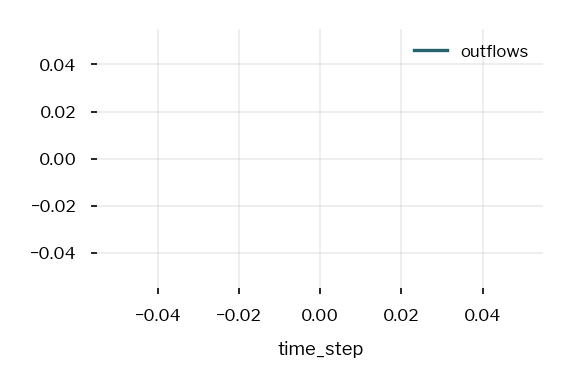

In [93]:
o[
    (o.policy_sim == "policy")
    & (o.sub_sim == "only_mj")
    & (o.compartment == "pretrial")
    & (o.outflow_to == "prison")
    #   (o.policy_sim=='policy')&
][["time_step", "outflows"]].set_index("time_step").plot()

In [100]:
c.shape[0] + p.shape[0]

10998

##### policy_sim.get_all_sub_simulation_tags()

In [28]:
comp = policy_sim._get_all_compartments()

all_outflows_tables = {tag: c.outflows.T for tag, c in comp.items()}
outflows = pd.concat(all_outflows_tables)

In [44]:
t = 0
for tag, o in all_outflows_tables.items():
    t += o.shape[0] * o.shape[1]
t

10998

In [45]:
outflows_raw = (
    outflows.melt(
        value_vars=list(outflows.columns),
        var_name="outflow_to",
        value_name="counts",
        ignore_index=False,
    )
    .reset_index()
    .dropna(subset="counts")
)

In [46]:
outflows_raw.columns = [
    "policy_sim",
    "sub_sim",
    "compartment",
    "compartment_type",
    "time_step",
    "outflow_to",
    "counts",
]

In [48]:
outflows_raw.shape

(10998, 7)

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_57132/3066392526.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for compartment, results in policy_results.groupby(["compartment"]):


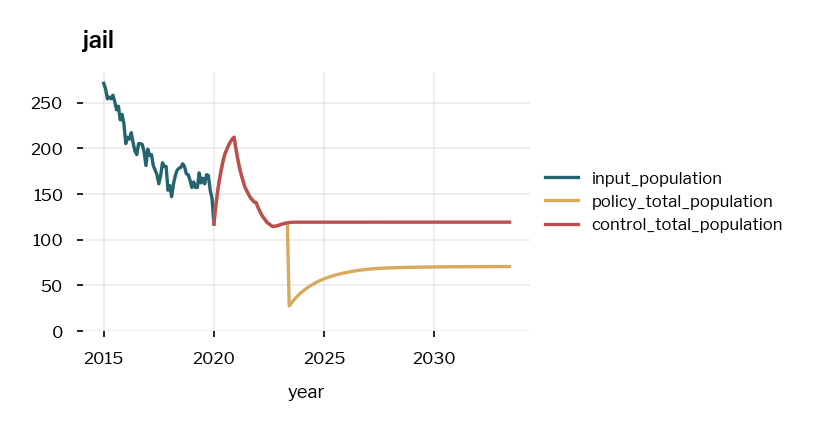

<Figure size 576x336 with 0 Axes>

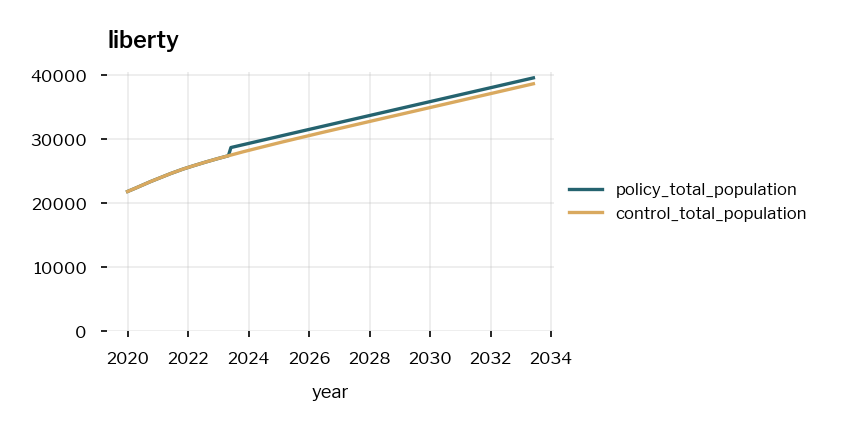

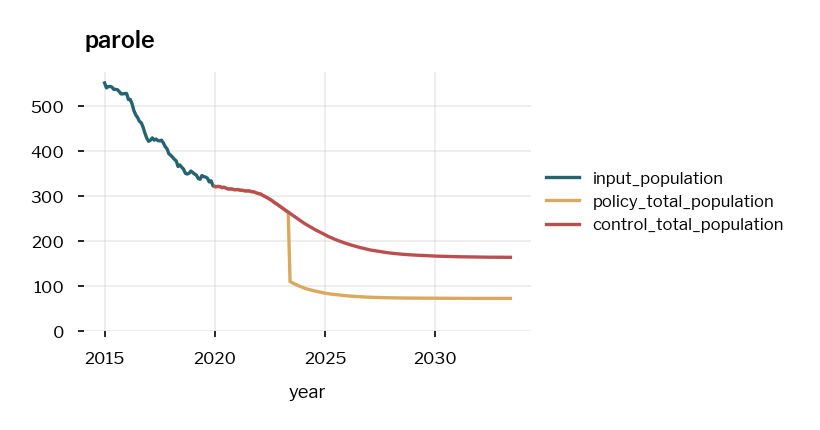

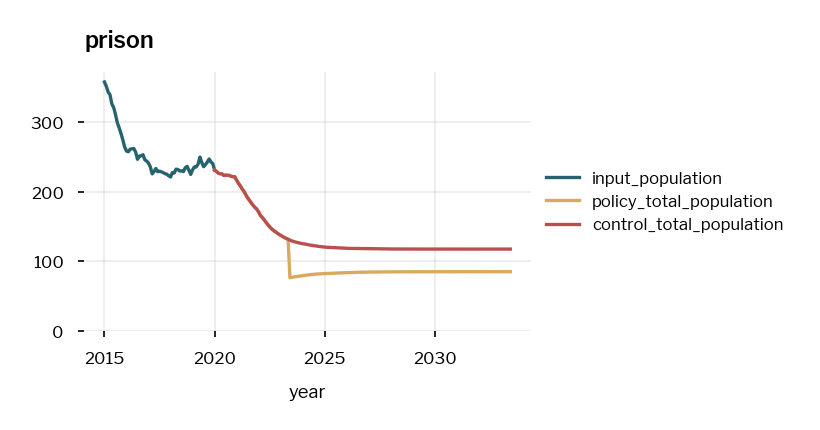

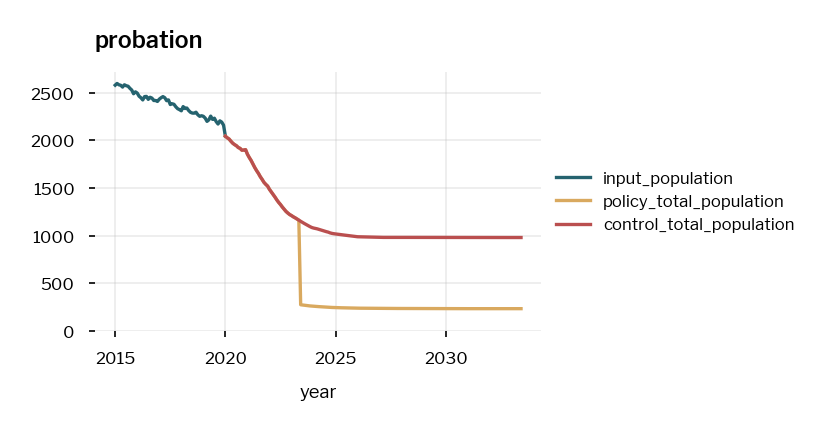

In [15]:
total_population_data = policy_sim.initializer.data_inputs.total_population_data.copy()
total_population_data[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    total_population_data["time_step"]
)
total_population_data = total_population_data.set_index(
    ["crime_type", "compartment", "year"]
).sort_index()["total_population"]

for compartment, results in policy_results.groupby(["compartment"]):
    plt.figure()
    ax = None
    if compartment in total_population_data.index.get_level_values("compartment"):
        ax = (
            total_population_data[
                total_population_data.index.get_level_values("compartment")
                == compartment
            ]
            .groupby("year")
            .sum()
            .plot(label="input_population")
        )
    results.groupby("year")[
        ["policy_total_population", "control_total_population"]
    ].sum().plot(ax=ax)
    add_legend()
    plt.ylim(0)
    plt.title(f"{compartment}")

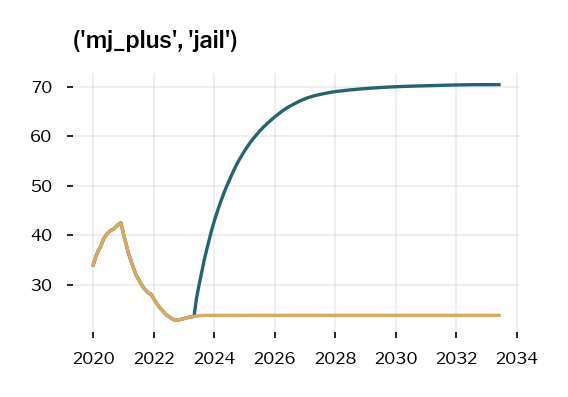

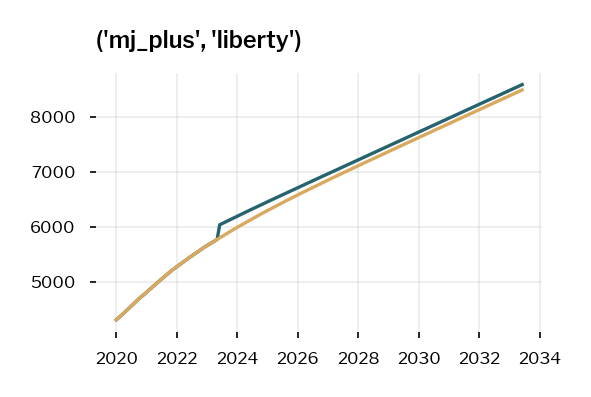

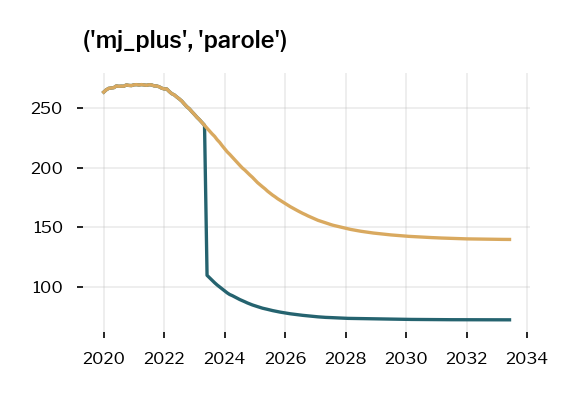

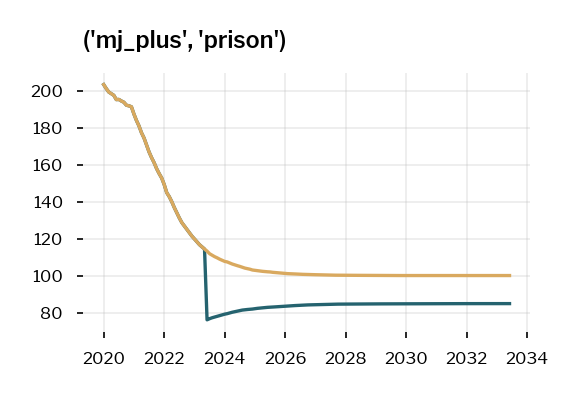

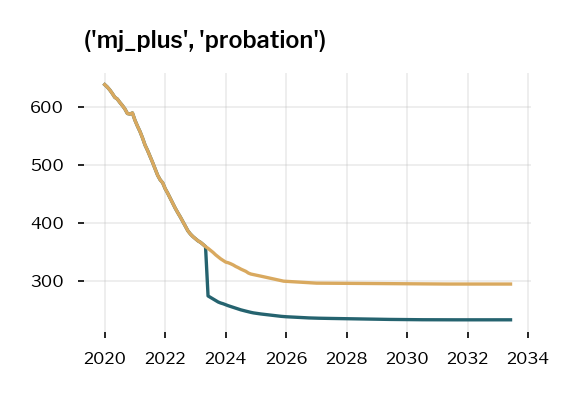

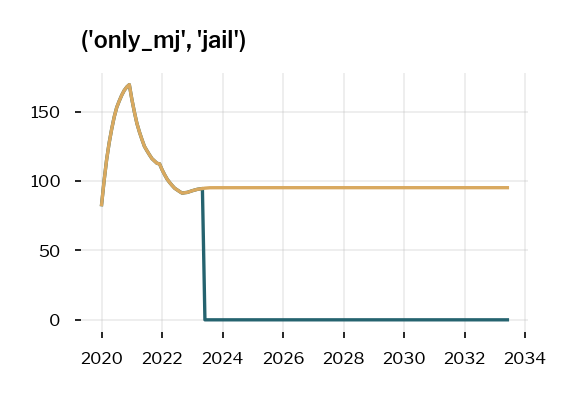

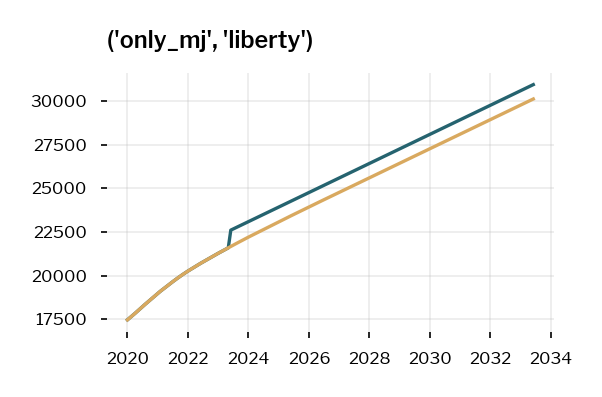

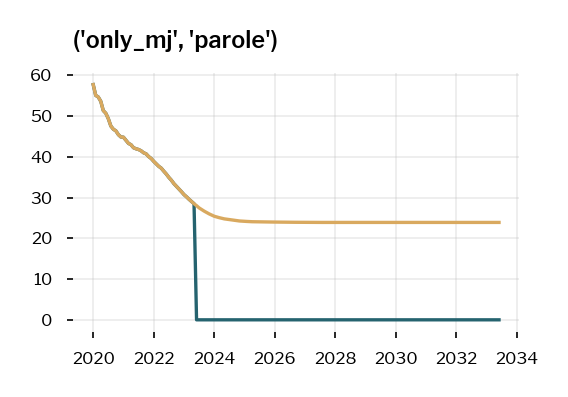

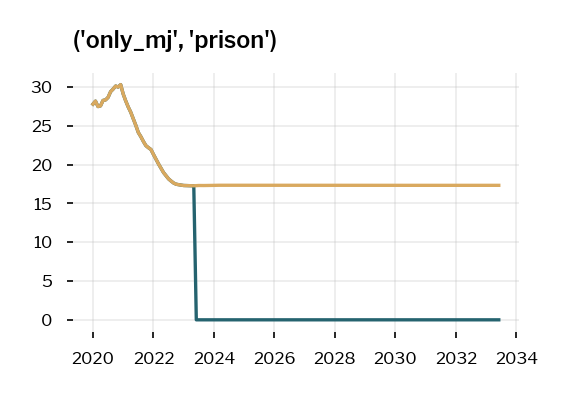

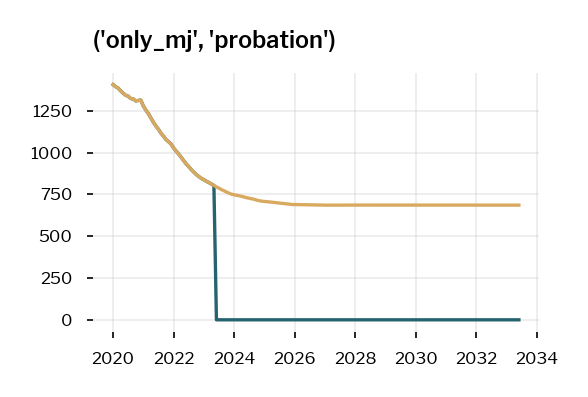

In [16]:
x = 1
for group, results in policy_results.groupby(["simulation_group", "compartment"]):
    plt.figure(x)
    plt.plot(results[["policy_total_population", "control_total_population"]])
    plt.title(f"{group}")
    x += 1
#     policy_results.reset_index().pivot(index='year',columns=['simulation_group','compartment'],values=['policy_total_population','control_total_population']).plot()

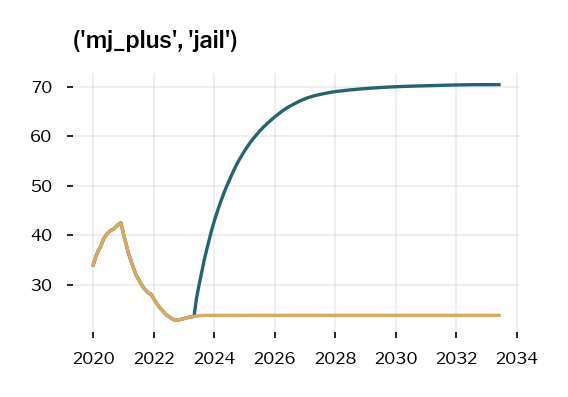

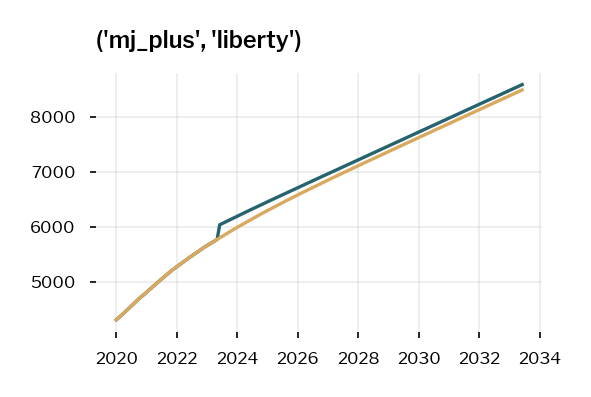

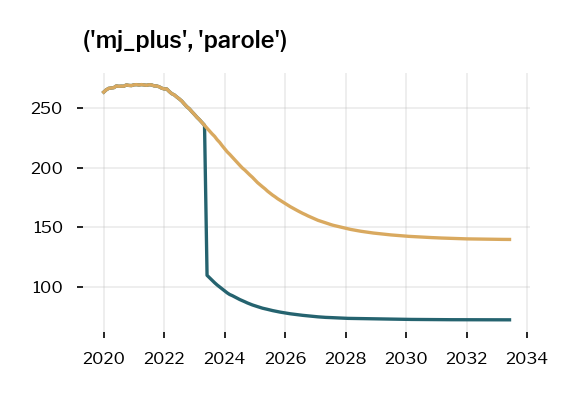

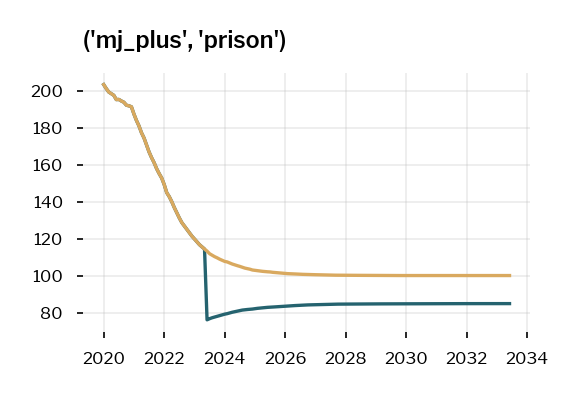

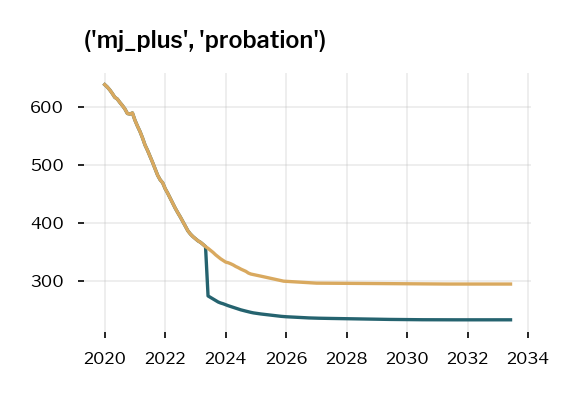

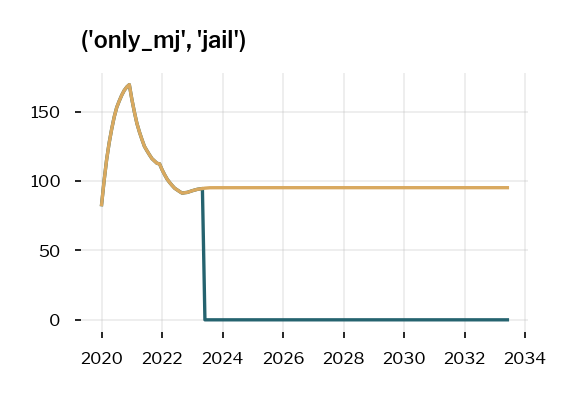

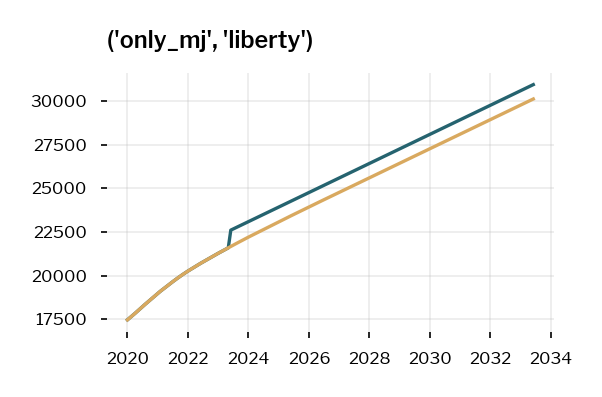

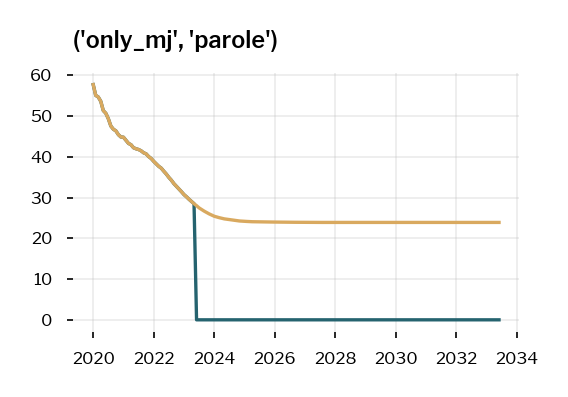

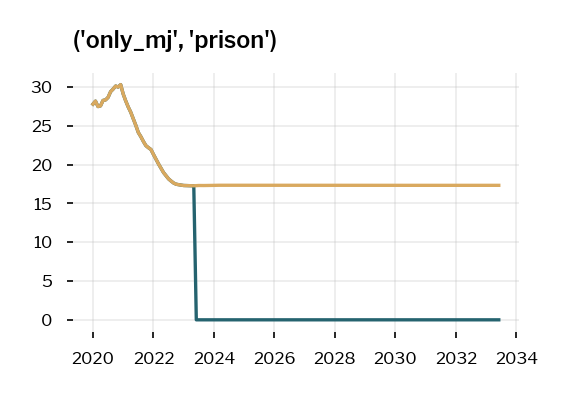

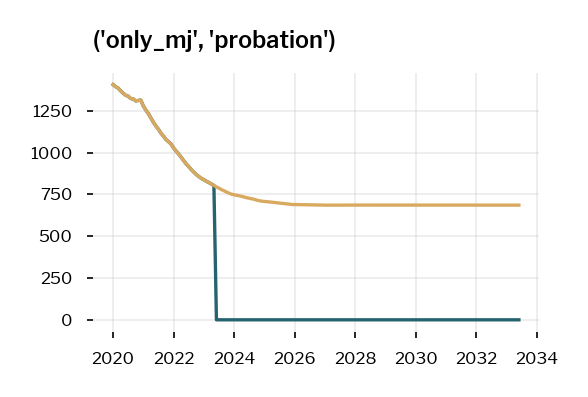

In [17]:
x = 1
for group, results in policy_results.groupby(["simulation_group", "compartment"]):
    #     display(results.head())
    plt.figure(x)
    #     print(group)
    #     display(
    #         pd.concat(
    #             [
    #                 results.sort_values("control_total_population", ascending=False).head(
    #                     1
    #                 ),
    #                 results.sort_values("control_total_population", ascending=False).head(
    #                     1
    #                 ),
    #             ]
    #         )
    #     )
    #     print(f"maxes at ")
    plt.plot(results[["policy_total_population", "control_total_population"]])
    plt.title(f"{group}")
    x += 1
#     policy_results.reset_index().pivot(index='year',columns=['simulation_group','compartment'],values=['policy_total_population','control_total_population']).plot()

In [32]:
policy_results[(policy_results.index > 2022.9) & (policy_results.index <= 2022.99)]

compartment  control_total_population simulation_group  \
year                                                                 
2022.916667      prison                121.357086          mj_plus   
2022.916667      parole                247.547960          mj_plus   
2022.916667        jail                 23.056161          mj_plus   
2022.916667   probation                377.044639          mj_plus   
2022.916667     liberty               5631.120380          mj_plus   
2022.916667      prison                 17.360256          only_mj   
2022.916667      parole                 31.468258          only_mj   
2022.916667        jail                 92.430095          only_mj   
2022.916667   probation                845.374390          only_mj   
2022.916667     liberty              21202.989451          only_mj   

             policy_total_population  population_difference  
year                                                         
2022.916667               121.357086                    0.0  
2022.916667               247.547960                    0.0  
2022.916667                23.056161                    0.0  
2022.916667               377.044639                    0.0  
2022.916667              5631.120380                    0.0  
2022.916667                17.360256                    0.0  
2022.916667                31.468258                    0.0  
2022.916667                92.430095                    0.0  
2022.916667               845.374390                    0.0  
2022.916667             21202.989451                    0.0

In [33]:
policy_results[(policy_results.index > 2023.9) & (policy_results.index <= 2023.99)]

compartment  control_total_population simulation_group  \
year                                                                 
2023.916667      prison                108.227561          mj_plus   
2023.916667      parole                218.877896          mj_plus   
2023.916667        jail                 23.845709          mj_plus   
2023.916667   probation                335.796589          mj_plus   
2023.916667     liberty               5966.079617          mj_plus   
2023.916667      prison                 17.320602          only_mj   
2023.916667      parole                 25.725584          only_mj   
2023.916667        jail                 95.178368          only_mj   
2023.916667   probation                750.849328          only_mj   
2023.916667     liberty              22133.013739          only_mj   

             policy_total_population  population_difference  
year                                                         
2023.916667                62.256365             -45.971196  
2023.916667                69.907777            -148.970119  
2023.916667                34.655669              10.809961  
2023.916667               201.192037            -134.604552  
2023.916667              6284.815805             318.736188  
2023.916667                 0.000000             -17.320602  
2023.916667                 0.000000             -25.725584  
2023.916667                 0.000000             -95.178368  
2023.916667                 0.000000            -750.849328  
2023.916667             23022.088051             889.074312

In [34]:
policy_results[
    (policy_results.index > 2022.9) & (policy_results.index <= 2022.99)
].groupby("compartment").sum()

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_49956/3598819476.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  policy_results[


control_total_population  policy_total_population  \
compartment                                                      
jail                       115.486256               115.486256   
liberty                  26834.109830             26834.109830   
parole                     279.016217               279.016217   
prison                     138.717342               138.717342   
probation                 1222.419029              1222.419029   

             population_difference  
compartment                         
jail                           0.0  
liberty                        0.0  
parole                         0.0  
prison                         0.0  
probation                      0.0

In [35]:
policy_results[(policy_results.compartment == "prison") & (policy_results.index < 2024)]

compartment  control_total_population simulation_group  \
year                                                                 
2020.000000      prison                203.192833          mj_plus   
2020.083333      prison                200.966431          mj_plus   
2020.166667      prison                199.192980          mj_plus   
2020.250000      prison                198.143228          mj_plus   
2020.333333      prison                197.353839          mj_plus   
2020.416667      prison                195.083876          mj_plus   
2020.500000      prison                195.125648          mj_plus   
2020.583333      prison                194.343262          mj_plus   
2020.666667      prison                193.524298          mj_plus   
2020.750000      prison                191.880427          mj_plus   
2020.833333      prison                191.720819          mj_plus   
2020.916667      prison                191.239492          mj_plus   
2021.000000      prison                187.162548          mj_plus   
2021.083333      prison                183.749155          mj_plus   
2021.166667      prison                180.794705          mj_plus   
2021.250000      prison                177.188483          mj_plus   
2021.333333      prison                174.233614          mj_plus   
2021.416667      prison                170.301490          mj_plus   
2021.500000      prison                166.769006          mj_plus   
2021.583333      prison                163.541845          mj_plus   
2021.666667      prison                161.012583          mj_plus   
2021.750000      prison                157.797520          mj_plus   
2021.833333      prison                155.183313          mj_plus   
2021.916667      prison                152.723022          mj_plus   
2022.000000      prison                149.281949          mj_plus   
2022.083333      prison                144.881778          mj_plus   
2022.166667      prison                142.631388          mj_plus   
2022.250000      prison                139.844086          mj_plus   
2022.333333      prison                136.643405          mj_plus   
2022.416667      prison                133.818715          mj_plus   
2022.500000      prison                131.155468          mj_plus   
2022.583333      prison                128.628615          mj_plus   
2022.666667      prison                126.682455          mj_plus   
2022.750000      prison                124.842985          mj_plus   
2022.833333      prison                123.092851          mj_plus   
2022.916667      prison                121.357086          mj_plus   
2023.000000      prison                119.815097          mj_plus   
2023.083333      prison                118.177691          mj_plus   
2023.166667      prison                116.617786          mj_plus   
2023.250000      prison                115.455614          mj_plus   
2023.333333      prison                114.310441          mj_plus   
2023.416667      prison                112.954962          mj_plus   
2023.500000      prison                111.903499          mj_plus   
2023.583333      prison                111.093913          mj_plus   
2023.666667      prison                110.205613          mj_plus   
2023.750000      prison                109.557284          mj_plus   
2023.833333      prison                108.847543          mj_plus   
2023.916667      prison                108.227561          mj_plus   
2020.000000      prison                 27.794496          only_mj   
2020.083333      prison                 28.201025          only_mj   
2020.166667      prison                 27.471234          only_mj   
2020.250000      prison                 27.585625          only_mj   
2020.333333      prison                 28.263828          only_mj   
2020.416667      prison                 28.348351          only_mj   
2020.500000      prison                 28.668337          only_mj   
2020.583333      priso

In [36]:
from IPython.display import display

policy_results[
    (policy_results.index > 2022.9) & (policy_results.index <= 2022.99)
].sort_values(["simulation_group"])

compartment  control_total_population simulation_group  \
year                                                                 
2022.916667      prison                121.357086          mj_plus   
2022.916667      parole                247.547960          mj_plus   
2022.916667        jail                 23.056161          mj_plus   
2022.916667   probation                377.044639          mj_plus   
2022.916667     liberty               5631.120380          mj_plus   
2022.916667      prison                 17.360256          only_mj   
2022.916667      parole                 31.468258          only_mj   
2022.916667        jail                 92.430095          only_mj   
2022.916667   probation                845.374390          only_mj   
2022.916667     liberty              21202.989451          only_mj   

             policy_total_population  population_difference  
year                                                         
2022.916667               121.357086                    0.0  
2022.916667               247.547960                    0.0  
2022.916667                23.056161                    0.0  
2022.916667               377.044639                    0.0  
2022.916667              5631.120380                    0.0  
2022.916667                17.360256                    0.0  
2022.916667                31.468258                    0.0  
2022.916667                92.430095                    0.0  
2022.916667               845.374390                    0.0  
2022.916667             21202.989451                    0.0

In [37]:
policy_results.head()

compartment  control_total_population simulation_group  \
year                                                                 
2020.000000      prison                203.192833          mj_plus   
2020.083333      prison                200.966431          mj_plus   
2020.166667      prison                199.192980          mj_plus   
2020.250000      prison                198.143228          mj_plus   
2020.333333      prison                197.353839          mj_plus   

             policy_total_population  population_difference  
year                                                         
2020.000000               203.192833                    0.0  
2020.083333               200.966431                    0.0  
2020.166667               199.192980                    0.0  
2020.250000               198.143228                    0.0  
2020.333333               197.353839                    0.0

In [38]:
policy_sim.initializer.data_inputs.total_population_data.head()

simulation_tag  time_step compartment  total_population  \
0  pa_mj_decrim_2023_full_mapping_v3        -60      parole        277.838844   
1  pa_mj_decrim_2023_full_mapping_v3        -60      prison        242.760641   
2  pa_mj_decrim_2023_full_mapping_v3        -60   probation        660.000000   
3  pa_mj_decrim_2023_full_mapping_v3        -59      parole        279.512572   
4  pa_mj_decrim_2023_full_mapping_v3        -59      prison        237.434369   

  crime crime_type   age  race                     date_created  
0  None    mj_plus  None  None 2023-03-07 13:07:55.334771+00:00  
1  None    mj_plus  None  None 2023-03-07 13:07:55.334771+00:00  
2  None    mj_plus  None  None 2023-03-07 13:07:55.334771+00:00  
3  None    mj_plus  None  None 2023-03-07 13:07:55.334771+00:00  
4  None    mj_plus  None  None 2023-03-07 13:07:55.334771+00:00

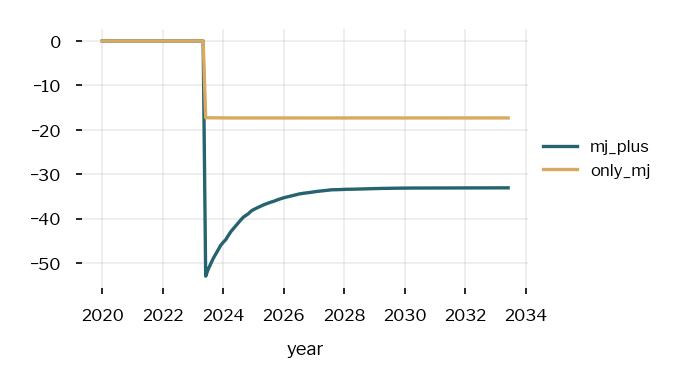

In [39]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "population_difference"
].unstack("simulation_group").plot()
add_legend()

/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_49956/4144902263.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  policy_results.groupby(["compartment", "year"]).sum()["population_difference"].unstack(


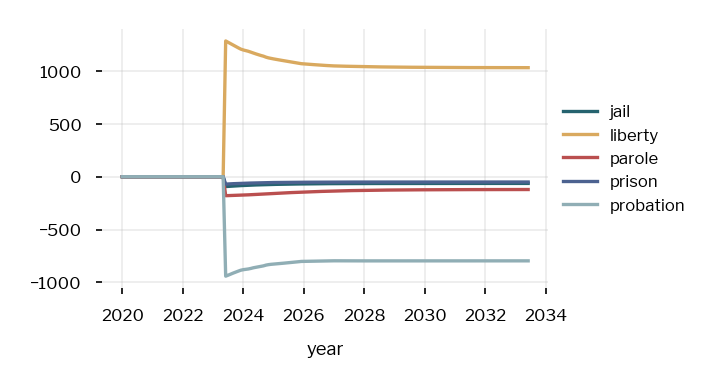

In [40]:
policy_results.groupby(["compartment", "year"]).sum()["population_difference"].unstack(
    "compartment"
).plot()
add_legend()

<AxesSubplot: xlabel='year'>

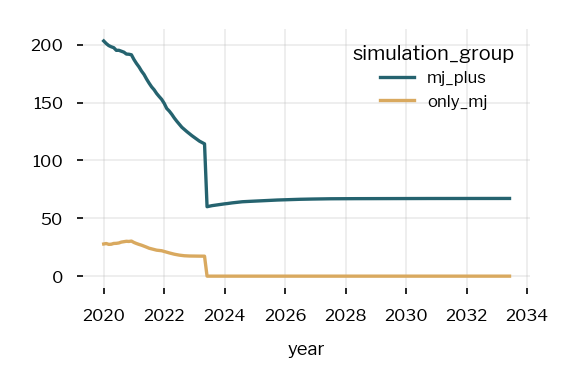

In [41]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "policy_total_population"
].unstack("simulation_group").plot()

In [ ]:
policy_sim.get_arima_output_plots(simulation_title="control", by_simulation_group=True)

In [ ]:
policy_sim.get_arima_output_plots(
    simulation_title="baseline_projections", by_simulation_group=True
)

In [ ]:
policy_sim.simulate_baseline(["prison"])

In [ ]:
baseline_output = policy_sim.validator.pop_simulations["control"].population_projections
baseline_output.set_index(["compartment", "time_step", "simulation_group"]).loc[
    "prison", "total_population"
].unstack("simulation_group").plot()
add_legend()
plt.title("FED HB 5977 Population Projection")

In [ ]:
baseline_outflows = (
    policy_sim.validator.pop_simulations["control"].get_outflows().copy()
)
baseline_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    baseline_outflows.index.get_level_values("time_step")
)
baseline_outflows = baseline_outflows[baseline_outflows["compartment"] != "release"]
baseline_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Baseline Simulation Projected Transitions")

In [ ]:
policy_outflows = policy_sim.validator.pop_simulations["policy"].get_outflows().copy()
policy_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    policy_outflows.index.get_level_values("time_step")
)
policy_outflows = policy_outflows[policy_outflows["compartment"] != "release"]
policy_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Policy Simulation Projected Transitions")

In [ ]:
policy_outflows[policy_outflows["simulation_group"] == "100"].loc["prison"]

In [ ]:
outflows_diff = baseline_outflows.reset_index(drop=False).merge(
    policy_outflows.reset_index(drop=False),
    how="inner",
    on=["time_step", "outflow_to", "compartment", "simulation_group", "year"],
    suffixes=("_control", "_policy"),
)
outflows_diff["outflows_difference"] = (
    outflows_diff["total_population_policy"] - outflows_diff["total_population_control"]
)
outflows_diff["actual_year"] = np.floor(outflows_diff["year"])
outflows_diff[
    (outflows_diff["compartment"] == "pretrial") & (outflows_diff["year"] >= 2022)
]

In [ ]:
outflows_diff.set_index(["outflow_to", "year", "simulation_group"]).loc[
    "prison", "outflows_difference"
].unstack(["simulation_group"]).plot()

In [ ]:
outflows_diff.head()

In [ ]:
cummulative_outflows_diff = (
    outflows_diff.groupby(["outflow_to", "year"])
    .sum()
    .loc["prison", "outflows_difference"]
    .cumsum()
)
cummulative_outflows_diff.plot()

In [ ]:
cummulative_outflows_diff[
    (cummulative_outflows_diff.index.get_level_values("year") % 1) > 0.9
]

In [ ]:
outflows_diff[outflows_diff["outflow_to"] == "prison"].groupby("actual_year").sum()[
    "outflows_difference"
]

In [ ]:
%%bigquery transitions_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_h5977'
    AND date_created = latest_runs.latest_run
ORDER BY compartment, compartment_duration

In [ ]:
transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]).loc[
    "prison"
].unstack("crime_type")["total_population"].plot()

In [ ]:
transitions_df.set_index(["compartment", "crime_type", "compartment_duration"]).loc[
    "prison", "5"
]

In [ ]:
%%bigquery population_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_h5977'
    AND date_created = latest_runs.latest_run
ORDER BY time_step

In [ ]:
population_df[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    population_df["time_step"]
)

In [ ]:
population_df.set_index(["compartment", "year", "crime_type"]).loc["prison"].unstack(
    "crime_type"
)["total_population"].plot()

In [ ]:
for crime_type in ["20", "5"]:
    ax = (
        population_df[population_df["crime_type"] == crime_type]
        .set_index(["compartment", "year"])
        .loc["prison", "total_population"]
        .plot()
    )

    policy_results[policy_results["simulation_group"] == crime_type].groupby(
        ["compartment", "year"]
    ).sum().loc["prison", ["policy_total_population", "control_total_population"]].plot(
        ax=ax
    )
plt.legend().remove()

In [ ]:
policy_results.tail()

# RUN 1 - just prison policies


In [ ]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
policy_results["population_difference"] = (
    policy_results["policy_total_population"]
    - policy_results["control_total_population"]
)

In [ ]:
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

In [ ]:
policy_results.groupby(["compartment", "year", "simulation_group"]).sum().loc[
    "prison", "population_difference"
].unstack("simulation_group").plot()
add_legend()

In [ ]:
policy_results[policy_results.index >= 2020].groupby(
    ["compartment", "year", "simulation_group"]
).sum().loc["prison", "policy_total_population"].unstack("simulation_group").plot()

## OTHERS

In [ ]:
transition_dict = (
    policy_sim.validator.pop_simulations["policy"]
    .sub_simulations["20"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)

policy_ts = min(transition_dfs.keys())
for ts, transition_table in transition_dict[policy_ts].tables.items():
    #     if (policy_key != 15) & (transition_type == TransitionTableType.BEFORE):
    #         continue
    transition_table.plot()
    plt.title(f"{ts} Prison Transition Table")
    add_legend(title="Outflow To")

In [ ]:
transition_dict = (
    policy_sim.validator.pop_simulations["policy"]
    .sub_simulations["5"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)

policy_key = max(transition_dict.keys())
for ts, transition_table in transition_dict[policy_key].tables.items():
    transition_table.plot()
    plt.title(f"{ts} Prison Transition Table")
    add_legend(title="Outflow To")